# Evaluating language knowledge of ELL students from grades 8-12

## Import Libraries

In [96]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

import warnings 
warnings.filterwarnings('ignore')

import re
from wordcloud import WordCloud
from wordcloud import STOPWORDS

import nltk
nltk.download('wordnet')
from textblob import TextBlob
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Yana2\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Loading The Dataset

*Using Pandas Library, we’ll load the CSV file. Named it with ellTrainData for the dataset.*

In [111]:
ellTrainData = pd.read_csv('input/train.csv')

In [112]:
ellTrainData.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5


## Data Profiling & Cleaning

*Get the number of columns and rows*

In [113]:
ellTrainData.shape

(3911, 8)

In [114]:
ellTrainData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3911 entries, 0 to 3910
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   text_id      3911 non-null   object 
 1   full_text    3911 non-null   object 
 2   cohesion     3911 non-null   float64
 3   syntax       3911 non-null   float64
 4   vocabulary   3911 non-null   float64
 5   phraseology  3911 non-null   float64
 6   grammar      3911 non-null   float64
 7   conventions  3911 non-null   float64
dtypes: float64(6), object(2)
memory usage: 244.6+ KB


*From the info, we know that there are 3911 entries and 8 columns.*

In [115]:
ellTrainData.isnull().sum()

text_id        0
full_text      0
cohesion       0
syntax         0
vocabulary     0
phraseology    0
grammar        0
conventions    0
dtype: int64

*There are no null entries.*

In [116]:
ellTrainData.describe()

,cohesion,syntax,vocabulary,phraseology,grammar,conventions
count,3911.000000,3911.000000,3911.000000,3911.000000,3911.000000,3911.000000
mean,3.127077,3.028254,3.235745,3.116850,3.032856,3.081053
std,0.662542,0.644399,0.583148,0.655997,0.699841,0.671450
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.500000,2.500000,3.000000,2.500000,2.500000,2.500000
50%,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
75%,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


In [117]:
# Basic text cleaning function
def remove_noise(text):
    
    # Make lowercase
    text = text.apply(lambda x: " ".join(x.lower() for x in x.split()))
    
    # Remove whitespaces
    text = text.apply(lambda x: " ".join(x.strip() for x in x.split()))
    
    # Remove special characters
    text = text.apply(lambda x: "".join([" " if ord(i) < 32 or ord(i) > 126 else i for i in x]))
    
    # Remove punctuation
    text = text.str.replace('[^\w\s]', '')
    
    # Remove numbers
    text = text.str.replace('\d+', '')
    
    # Remove Stopwords
    text = text.apply(lambda x: ' '.join([word for word in x.split() if word not in (STOPWORDS)]))
    
    # Convert to string
    text = text.astype(str)
        
    return text

In [118]:
# Applying noise removal function to data
ellTrainData['filtered_text'] = remove_noise(ellTrainData['full_text'])
ellTrainData.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,filtered_text
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0,think students benefit learning homebecause wo...
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5,problem change let best matter happening chang...
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5,dear principal u change school policy grade b ...
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0,best time life become agree greatest accomplis...
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5,small act kindness impact people change people...


In [119]:
# Defining a sentiment analyser function
def sentiment_analyser(text):
    return text.apply(lambda Text: pd.Series(TextBlob(Text).sentiment.polarity))

# Applying function to reviews
ellTrainData['polarity'] = sentiment_analyser(ellTrainData['filtered_text'])
ellTrainData.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,filtered_text,polarity
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0,think students benefit learning homebecause wo...,0.040909
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5,problem change let best matter happening chang...,0.090862
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5,dear principal u change school policy grade b ...,0.055952
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0,best time life become agree greatest accomplis...,0.165434
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5,small act kindness impact people change people...,0.254419


## Lexicon Normalisation

In [120]:
# Instantiate the Word tokenizer & Word lemmatizer
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

# Define a word lemmatizer function
def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

# Apply the word lemmatizer function to data
ellTrainData['filtered_text'] = ellTrainData['filtered_text'].apply(lemmatize_text)
ellTrainData.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,filtered_text,polarity
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0,"[think, student, benefit, learning, homebecaus...",0.040909
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5,"[problem, change, let, best, matter, happening...",0.090862
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5,"[dear, principal, u, change, school, policy, g...",0.055952
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0,"[best, time, life, become, agree, greatest, ac...",0.165434
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5,"[small, act, kindness, impact, people, change,...",0.254419


## Exploratory Analysis and Visualization

In [121]:
ellTrainData['text_len'] = ellTrainData['full_text'].apply(lambda x: len(x))
ellTrainData['words_num'] = ellTrainData['full_text'].apply(lambda x: len(x.split()))

In [122]:
ellTrainData.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,filtered_text,polarity,text_len,words_num
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0,"[think, student, benefit, learning, homebecaus...",0.040909,1387,261
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5,"[problem, change, let, best, matter, happening...",0.090862,2635,533
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5,"[dear, principal, u, change, school, policy, g...",0.055952,1663,320
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0,"[best, time, life, become, agree, greatest, ac...",0.165434,3973,728
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5,"[small, act, kindness, impact, people, change,...",0.254419,1326,234


<AxesSubplot:xlabel='words_num', ylabel='Density'>

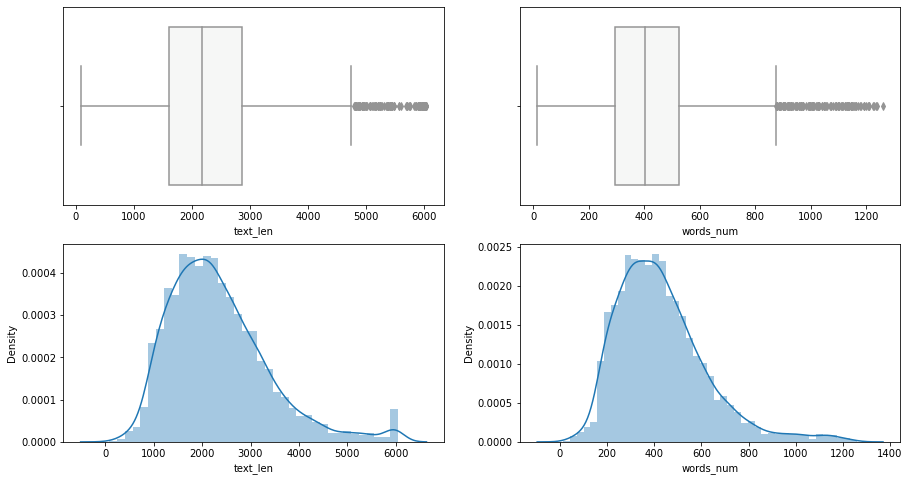

In [123]:
# Length of full_text and words num
fig, ax = plt.subplots(2, 2, figsize=(15, 8))
sns.boxplot(ellTrainData['text_len'], palette='PRGn', ax = ax[0, 0])
sns.distplot(ellTrainData['text_len'], ax = ax[1, 0])
sns.boxplot(ellTrainData['words_num'], palette='PRGn', ax = ax[0, 1])
sns.distplot(ellTrainData['words_num'], ax = ax[1, 1])

## WordCloud

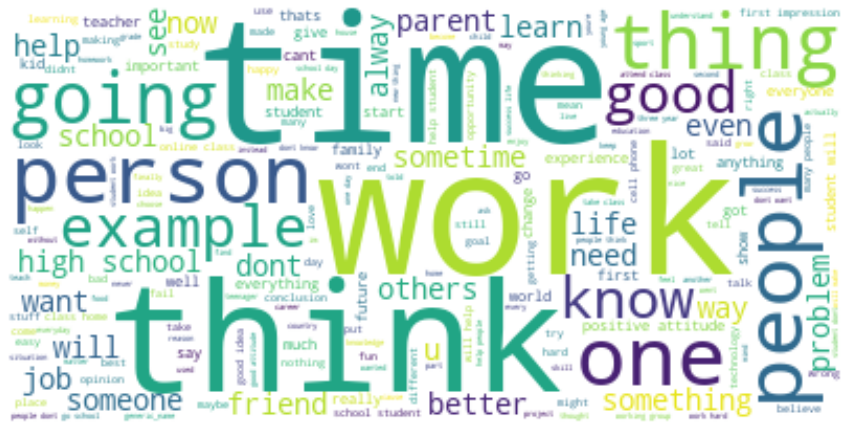

In [124]:
text = " ".join(j for i in ellTrainData['filtered_text'] for j in i)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Getting a text matrix

In [125]:
# Getting a count of words from the documents
# Ngram_range is set to 1,2 - meaning either single or two word combination will be extracted
cvec = CountVectorizer(min_df=.05, max_df=.9, ngram_range=(1,2), tokenizer=lambda x: x, lowercase=False)
cvec.fit(ellTrainData['filtered_text'])

CountVectorizer(lowercase=False, max_df=0.9, min_df=0.05, ngram_range=(1, 2),
                tokenizer=<function <lambda> at 0x000002B3656833A0>)

In [126]:
# Getting the total n-gram count
len(cvec.vocabulary_)

438

In [127]:
# Creating the bag-of-words representation
cvec_counts = cvec.transform(ellTrainData['filtered_text'])
print('sparse matrix shape:', cvec_counts.shape)
print('nonzero count:', cvec_counts.nnz)
print('sparsity: %.2f%%' % (100.0 * cvec_counts.nnz / (cvec_counts.shape[0] * cvec_counts.shape[1])))

sparse matrix shape: (3911, 438)
nonzero count: 244290
sparsity: 14.26%


In [128]:
# Instantiating the TfidfTransformer
transformer = TfidfTransformer()

# Fitting and transforming n-grams
transformed_weights = transformer.fit_transform(cvec_counts)
transformed_weights

<3911x438 sparse matrix of type '<class 'numpy.float64'>'
	with 244290 stored elements in Compressed Sparse Row format>

In [129]:
# Getting a list of all n-grams
transformed_weights = transformed_weights.toarray()
vocab = cvec.get_feature_names()

# Putting weighted n-grams into a DataFrame and computing some summary statistics
model = pd.DataFrame(transformed_weights, columns=vocab)
model['Keyword'] = model.idxmax(axis=1)
model['Max'] = model.max(axis=1)
model['Sum'] = model.drop('Max', axis=1).sum(axis=1)
model.head()

,able,accomplish,achieve,act,activity,actually,addition,adult,affect,age,...,worry,wouldnt,wrong,year,yes,young,youre,Keyword,Max,Sum
0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,cause,0.354638,6.224159
1,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.037536,0.0,0.0,0.0,0.000000,change,0.499273,5.302967
2,0.153764,0.0,0.0,0.000000,0.376831,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,sport,0.520886,5.416690
3,0.032137,0.0,0.0,0.095860,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.074572,0.0,0.0,0.0,0.275617,choice,0.427339,6.763265
4,0.000000,0.0,0.0,0.512906,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,act,0.512906,5.066954


### Merging datasets

In [130]:
# Merging td-idf weight matrix with original DataFrame
model = pd.merge(ellTrainData, model, left_index=True, right_index=True)
model.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,filtered_text,polarity,...,worry,wouldnt,wrong,year,yes,young,youre,Keyword,Max,Sum
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0,"[think, student, benefit, learning, homebecaus...",0.040909,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,cause,0.354638,6.224159
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5,"[problem, change, let, best, matter, happening...",0.090862,...,0.0,0.0,0.037536,0.0,0.0,0.0,0.000000,change,0.499273,5.302967
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5,"[dear, principal, u, change, school, policy, g...",0.055952,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,sport,0.520886,5.416690
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0,"[best, time, life, become, agree, greatest, ac...",0.165434,...,0.0,0.0,0.074572,0.0,0.0,0.0,0.275617,choice,0.427339,6.763265
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5,"[small, act, kindness, impact, people, change,...",0.254419,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,act,0.512906,5.066954


In [131]:
# Getting a view of the top 20 occurring words
occ = np.asarray(cvec_counts.sum(axis=0)).ravel().tolist()
counts_df = pd.DataFrame({'Term': cvec.get_feature_names(), 'Occurrences': occ})
counts_df.sort_values(by='Occurrences', ascending=False).head(25)

,Term,Occurrences
347,student,17046
268,people,15584
311,school,14229
420,will,11166
389,time,9231
143,good,8436
427,work,8360
202,life,7964
410,want,7854
215,make,7754


In [132]:
# Getting a view of the top 20 weights
weights = np.asarray(transformed_weights.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({'Term': cvec.get_feature_names(), 'Weight': weights})
weights_df.sort_values(by='Weight', ascending=False).head(25)

,Term,Weight
347,student,0.109647
268,people,0.085732
311,school,0.083948
420,will,0.064529
202,life,0.053098
427,work,0.052109
389,time,0.051110
143,good,0.049313
55,class,0.048928
158,help,0.048872


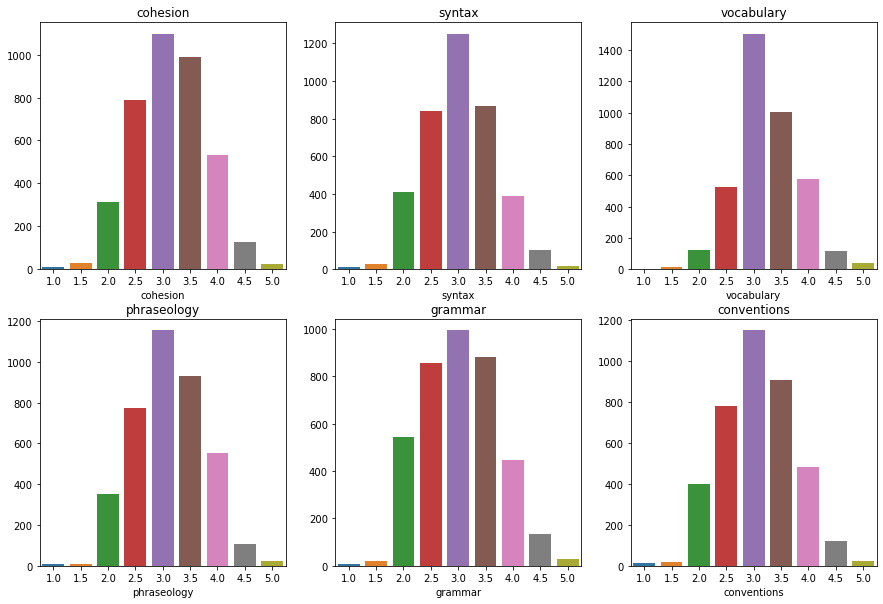

,cohesion,syntax,vocabulary,phraseology,grammar,conventions
1.0,10,11,2,10,8,15
1.5,27,29,14,11,20,20
2.0,315,410,124,350,544,402
2.5,790,839,528,772,855,784
3.0,1096,1250,1503,1153,994,1151
3.5,988,867,1007,929,880,908
4.0,534,388,577,553,447,484
4.5,125,100,115,108,134,122
5.0,26,17,41,25,29,25


In [133]:
# Countplot
scList = ['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']
plt.figure(figsize=(15, 10))
for i, c in enumerate(scList):
    ax = plt.subplot(2, 3, i+1)
    sns.countplot(data = model, x = c)
    ax.set(title = c)
    ax.set(ylabel=None)
plt.show()

# Value counts
model[scList].apply(pd.Series.value_counts)

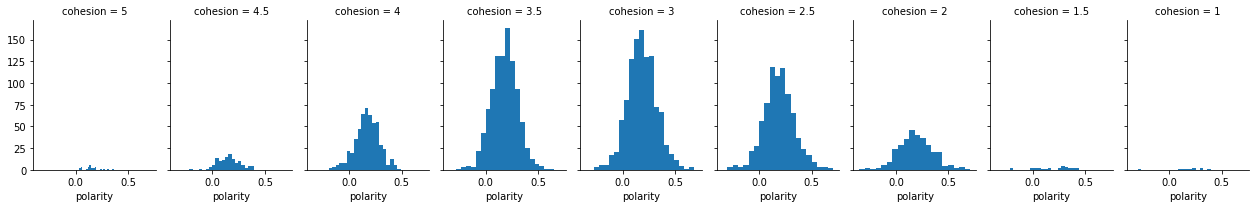

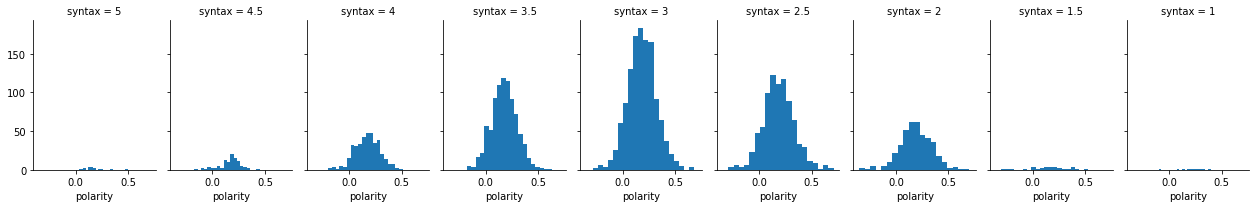

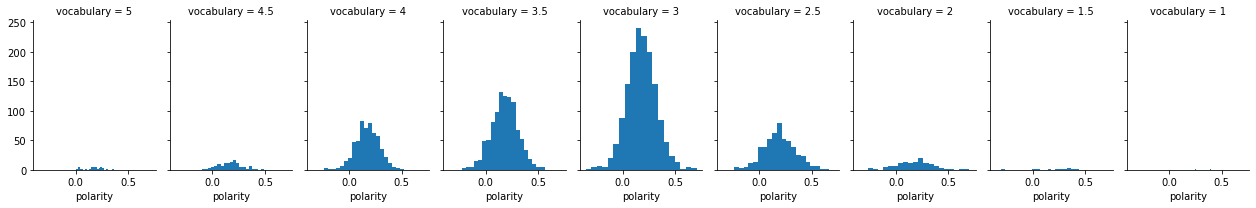

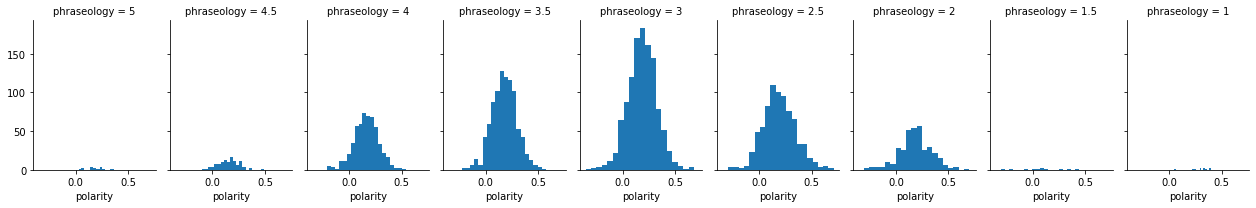

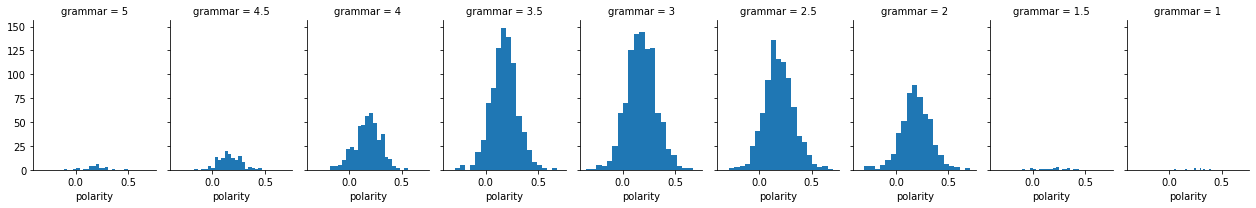

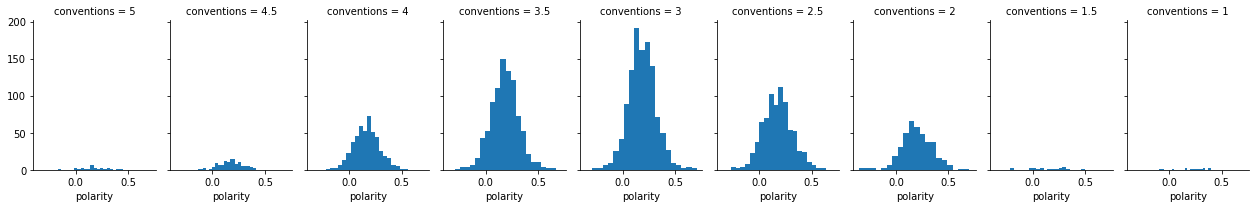

In [134]:
# Visualising polarity between scores
for score in scList:
    g = sns.FacetGrid(model, col=score, col_order=[5, 4.5, 4, 3.5, 3, 2.5, 2, 1.5, 1], aspect=.65)
    g = g.map(plt.hist, "polarity", bins=20)

## Machine Learning

In [143]:
# Drop all columns not part of the text matrix
ml_model = model.drop(['text_id', 'full_text', 'filtered_text', 'polarity', 'Keyword', 'Max', 'Sum'], axis=1)

In [144]:
# Create X & y variables for Machine Learning
X = ml_model.drop(scList, axis=1)
y = ml_model[scList]

# Create a train-test split of these variables
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

In [145]:
# Defining a function to fit and predict ML algorithms
def modelRes(mod, model_name, x_train, y_train, x_test, y_test):
    mod.fit(x_train, y_train)
    print(model_name)
    acc = cross_val_score(mod, X_train, y_train, scoring = "accuracy", cv = 5)
    predictions = cross_val_predict(mod, X_train, y_train, cv = 5)
    print("Accuracy:", round(acc.mean(),3))
    cm = confusion_matrix(predictions, y_train)
    print("Confusion Matrix:  \n", cm)
    print("Classification Report \n",classification_report(predictions, y_train))